In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time


import analytical_solution as anso
import functions as fu
import sparse_matrix as spma

In [ ]:
N = 1000    # Number of intervals between -L and L
L = 10
dt = 0.025
t_steps = 20000
omega = 1

#### INPUT PARAMETERS ####
N = 1000
omega = 1

x_i = np.array([(((2*L)/N)*i - L) for i in range(N)])

custom_wfc = np.zeros(N, dtype=complex)

# I initialize the wavefunction to the ground state (n=0)
# And centered in 0
wfcoffset=0     # W.f. offset --> it's x - x_0
n=1            # Order of the Hermite Polynomial --> correspond to the ground state

custom_wfc += anso.harmonic_wfc(x_i - 4, omega, n).astype(complex)




(-10.0, 10.0)

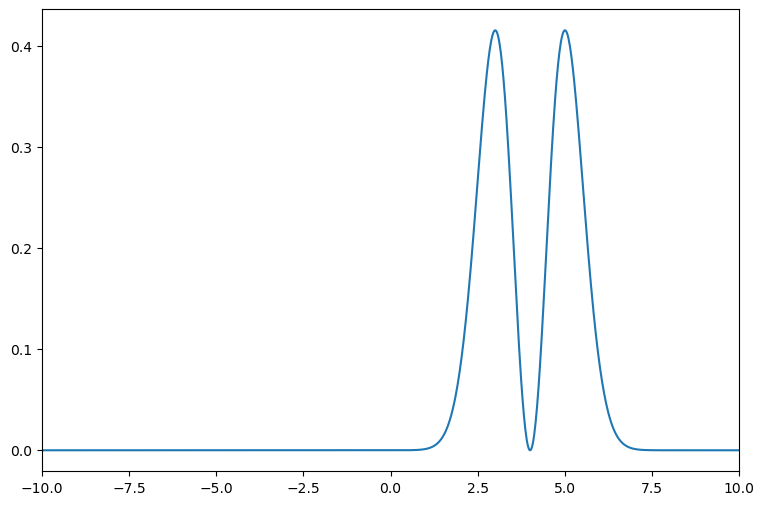

In [ ]:
density = (np.abs(custom_wfc))**2

plt.figure(figsize=(9,6))
plt.plot(x_i, density)
plt.xlim(-10,10)

In [ ]:
#### INPUT PARAMETERS ####
N = 1000
omega = 1
L = 5
k = 16

In [3]:
#### VARIABLES NEEDED TO BE COMPUTED ####
deltax = (2*L)/N
x_i = np.array([(((2*L)/N)*i - L) for i in range(N)])

## Analytical

In [4]:
number_to_print = 5

eigenvalues_analy, eigenvectors_analy = anso.analytic_eigenv(x_i, omega, k)

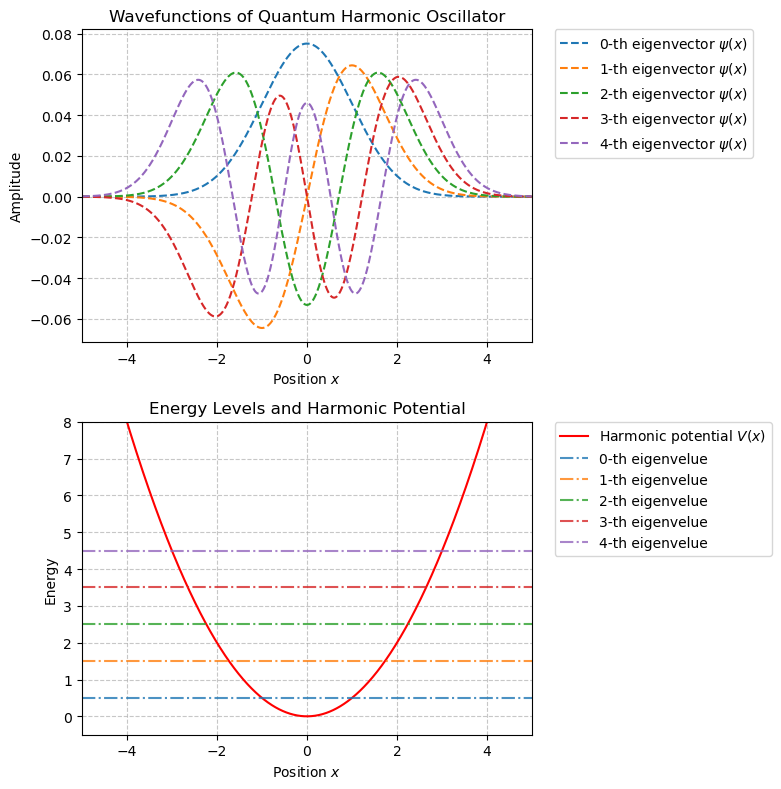

In [5]:
fu.plot(number_to_print, eigenvalues_analy, eigenvectors_analy, x_i, L, omega)

## Order 2

In [6]:
order = 2
A, eigenvalues_order2, eigenvectors_order2 = fu.hamiltonian_gen(N, deltax, x_i, omega, order)

eigenvalues_order2 = eigenvalues_order2[:k]
eigenvectors_order2 = eigenvectors_order2[:k]

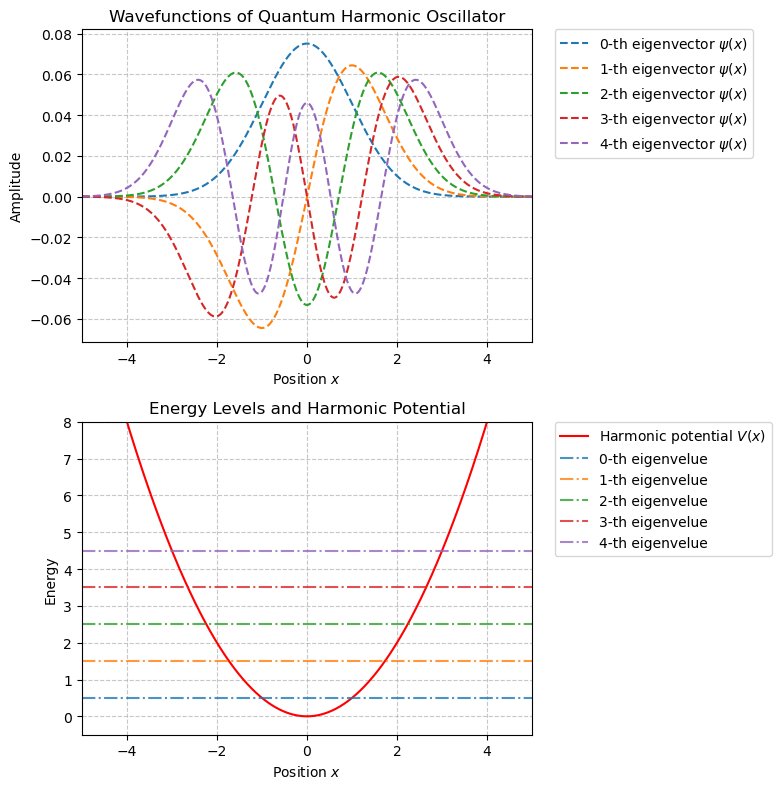

In [7]:
number_to_print = 5

fu.plot(number_to_print, eigenvalues_order2, eigenvectors_order2, x_i, L, omega)

## Order 4

In [8]:
order = 4
A, eigenvalues_order4, eigenvectors_order4 = fu.hamiltonian_gen(N, deltax, x_i, omega, order)

eigenvalues_order4 = eigenvalues_order4[:k]
eigenvectors_order4 = eigenvectors_order4[:k]

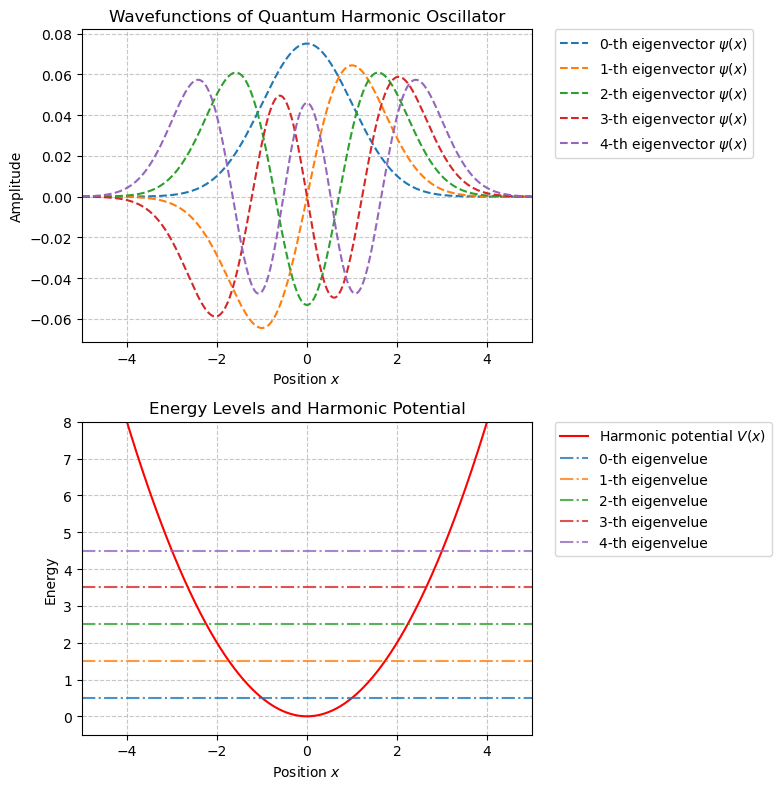

In [9]:
number_to_print = 5

fu.plot(number_to_print, eigenvalues_order4, eigenvectors_order4, x_i, L, omega)

## Correctness

I first consider the correctness w.r.t. the order 2 

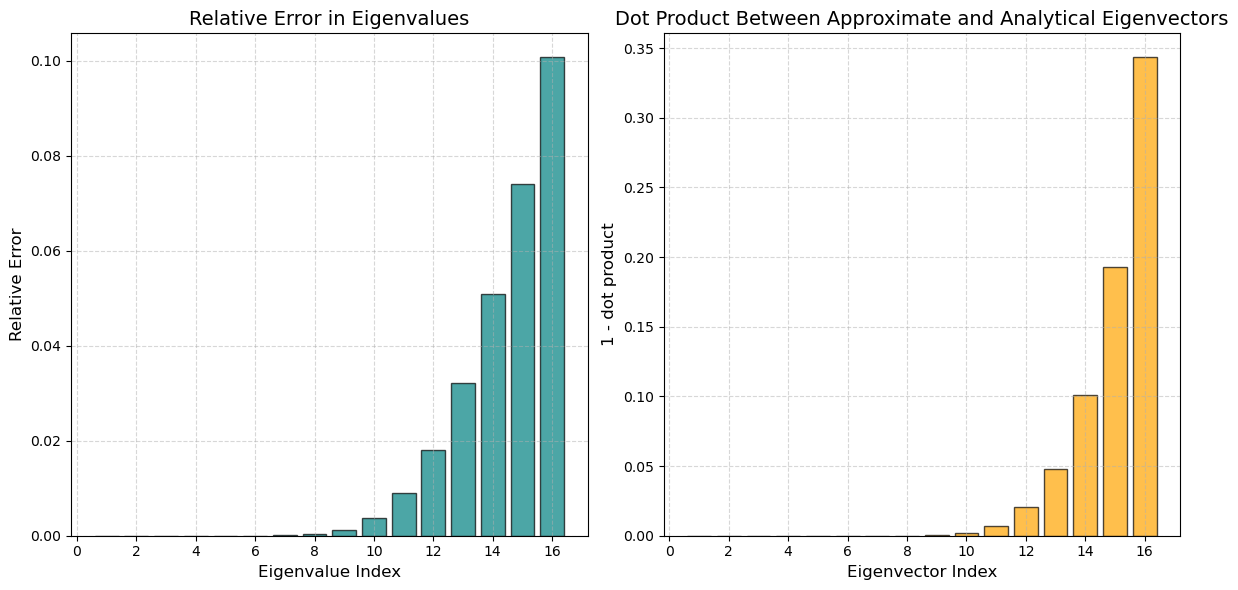

In [10]:
rel_eigval_err_order2, eigvec_dot_order2 = fu.correctness(k, eigenvalues_order2, eigenvectors_order2, eigenvalues_analy, eigenvectors_analy)

fu.plot_correctness(k, rel_eigval_err_order2, eigvec_dot_order2)

I then consider the correctness w.r.t. the degree 4

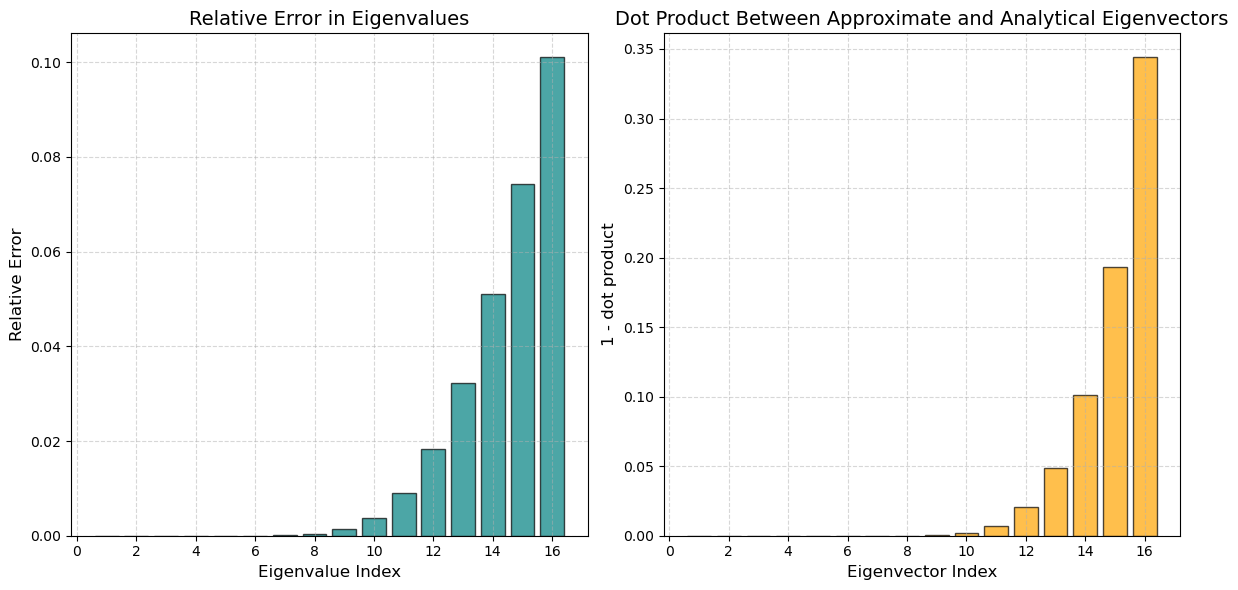

In [11]:
rel_eigval_err_order4, eigvec_dot_order4 = fu.correctness(k, eigenvalues_order4, eigenvectors_order4, eigenvalues_analy, eigenvectors_analy)

fu.plot_correctness(k, rel_eigval_err_order4, eigvec_dot_order4)

I plot in the same graph the 2 histograms in order to make a comparison

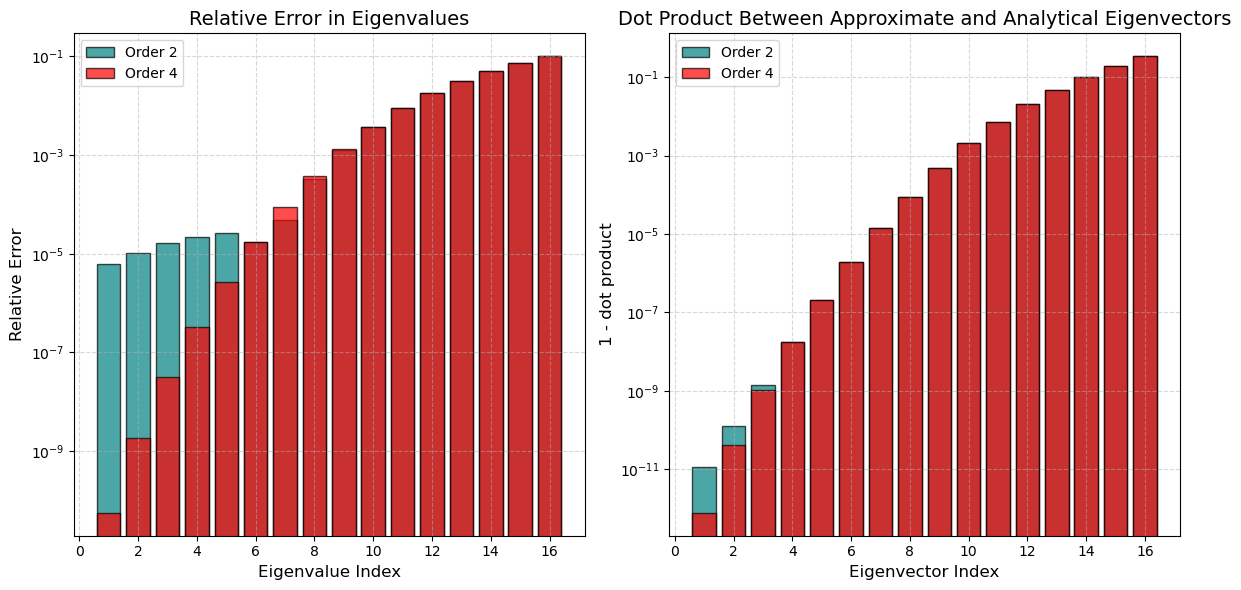

In [12]:
fu.plot_both_correctness(k, rel_eigval_err_order2, rel_eigval_err_order4, eigvec_dot_order2, eigvec_dot_order4)

## Stability

I start with Order 2, num_runs = 10

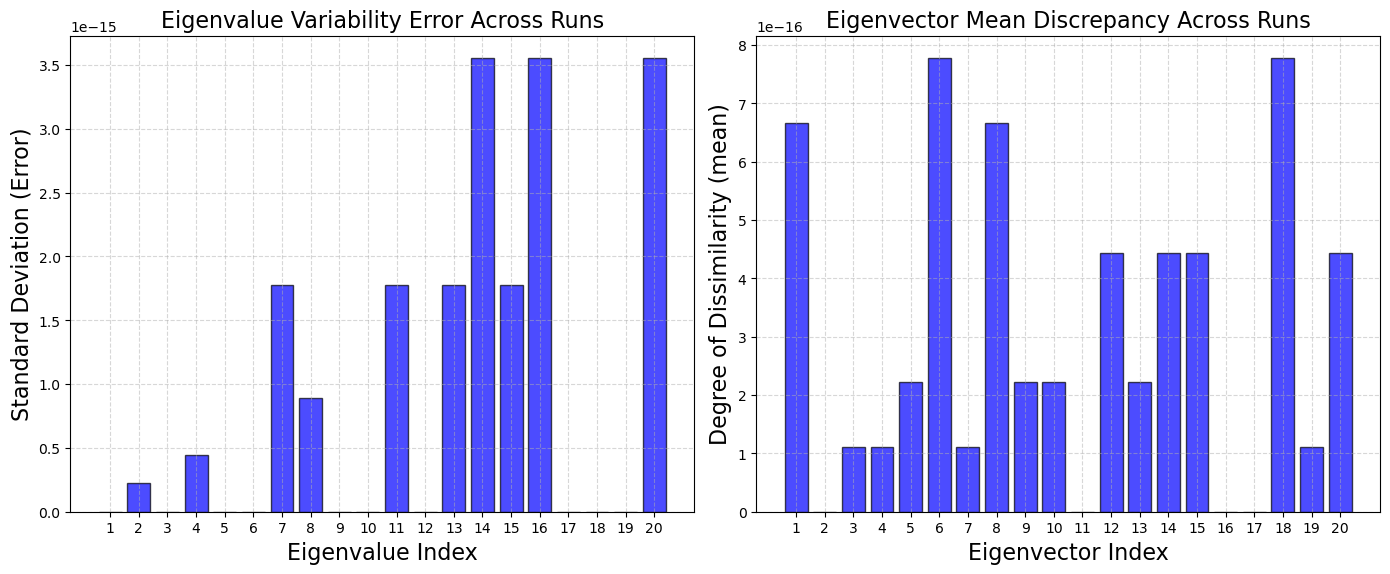

In [13]:
num_runs = 10
order = 2
k = 20

eigval_std, eigvec_dot_mean, dot_mat = fu.stability(num_runs, order, k, N, deltax, x_i, omega)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot the mean and std of eigenvalues
axes[0].bar(range(1, k + 1), eigval_std, color='blue', edgecolor='black', alpha=0.7)
# Labeling the plot
axes[0].set_title("Eigenvalue Variability Error Across Runs", fontsize=16)
axes[0].set_xlabel("Eigenvalue Index", fontsize=16)
axes[0].set_ylabel("Standard Deviation (Error)", fontsize=16)
axes[0].set_xticks(range(1, k + 1))
axes[0].grid(True, linestyle="--", alpha=0.5)

axes[1].bar(range(1, k + 1), eigvec_dot_mean, color='blue', edgecolor='black', alpha=0.7)
# Labeling the plot
axes[1].set_title("Eigenvector Mean Discrepancy Across Runs", fontsize=16)
axes[1].set_xlabel("Eigenvector Index", fontsize=16)
axes[1].set_ylabel("Degree of Dissimilarity (mean)", fontsize=16)
axes[1].set_xticks(range(1, k + 1))
axes[1].grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

Order 2, num_runs = 100

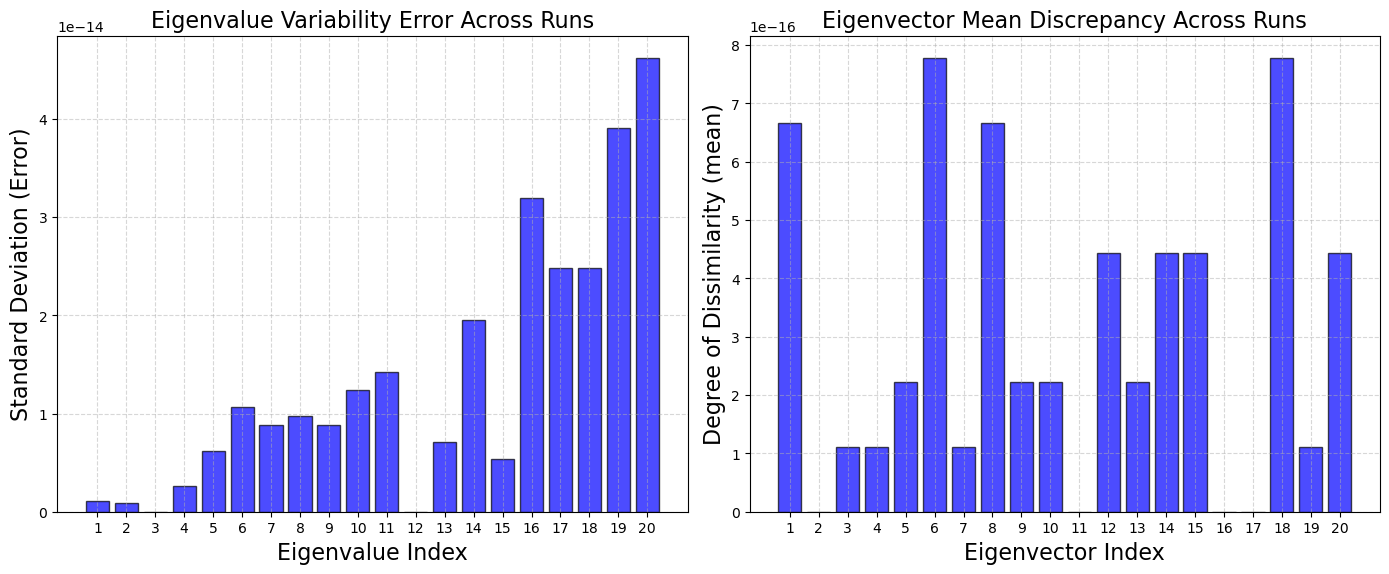

In [14]:
num_runs = 100
order = 2
k = 20

eigval_std, eigvec_dot_mean, dot_mat = fu.stability(num_runs, order, k, N, deltax, x_i, omega)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot the mean and std of eigenvalues
axes[0].bar(range(1, k + 1), eigval_std, color='blue', edgecolor='black', alpha=0.7)
# Labeling the plot
axes[0].set_title("Eigenvalue Variability Error Across Runs", fontsize=16)
axes[0].set_xlabel("Eigenvalue Index", fontsize=16)
axes[0].set_ylabel("Standard Deviation (Error)", fontsize=16)
axes[0].set_xticks(range(1, k + 1))
axes[0].grid(True, linestyle="--", alpha=0.5)

axes[1].bar(range(1, k + 1), eigvec_dot_mean, color='blue', edgecolor='black', alpha=0.7)
# Labeling the plot
axes[1].set_title("Eigenvector Mean Discrepancy Across Runs", fontsize=16)
axes[1].set_xlabel("Eigenvector Index", fontsize=16)
axes[1].set_ylabel("Degree of Dissimilarity (mean)", fontsize=16)
axes[1].set_xticks(range(1, k + 1))
axes[1].grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

Then with Order 4, num_runs = 10

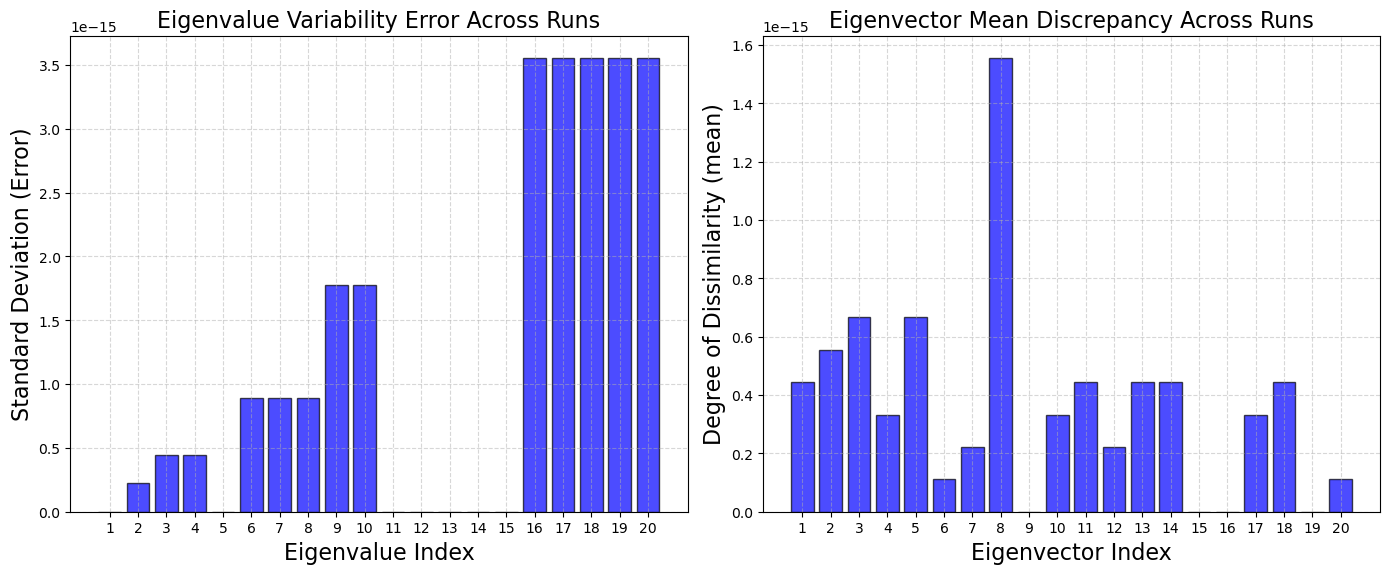

In [15]:
num_runs = 10
order = 4
k = 20

eigval_std, eigvec_dot_mean, dot_mat = fu.stability(num_runs, order, k, N, deltax, x_i, omega)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot the mean and std of eigenvalues
axes[0].bar(range(1, k + 1), eigval_std, color='blue', edgecolor='black', alpha=0.7)
# Labeling the plot
axes[0].set_title("Eigenvalue Variability Error Across Runs", fontsize=16)
axes[0].set_xlabel("Eigenvalue Index", fontsize=16)
axes[0].set_ylabel("Standard Deviation (Error)", fontsize=16)
axes[0].set_xticks(range(1, k + 1))
axes[0].grid(True, linestyle="--", alpha=0.5)

axes[1].bar(range(1, k + 1), eigvec_dot_mean, color='blue', edgecolor='black', alpha=0.7)
# Labeling the plot
axes[1].set_title("Eigenvector Mean Discrepancy Across Runs", fontsize=16)
axes[1].set_xlabel("Eigenvector Index", fontsize=16)
axes[1].set_ylabel("Degree of Dissimilarity (mean)", fontsize=16)
axes[1].set_xticks(range(1, k + 1))
axes[1].grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

Order 4, num_runs = 100

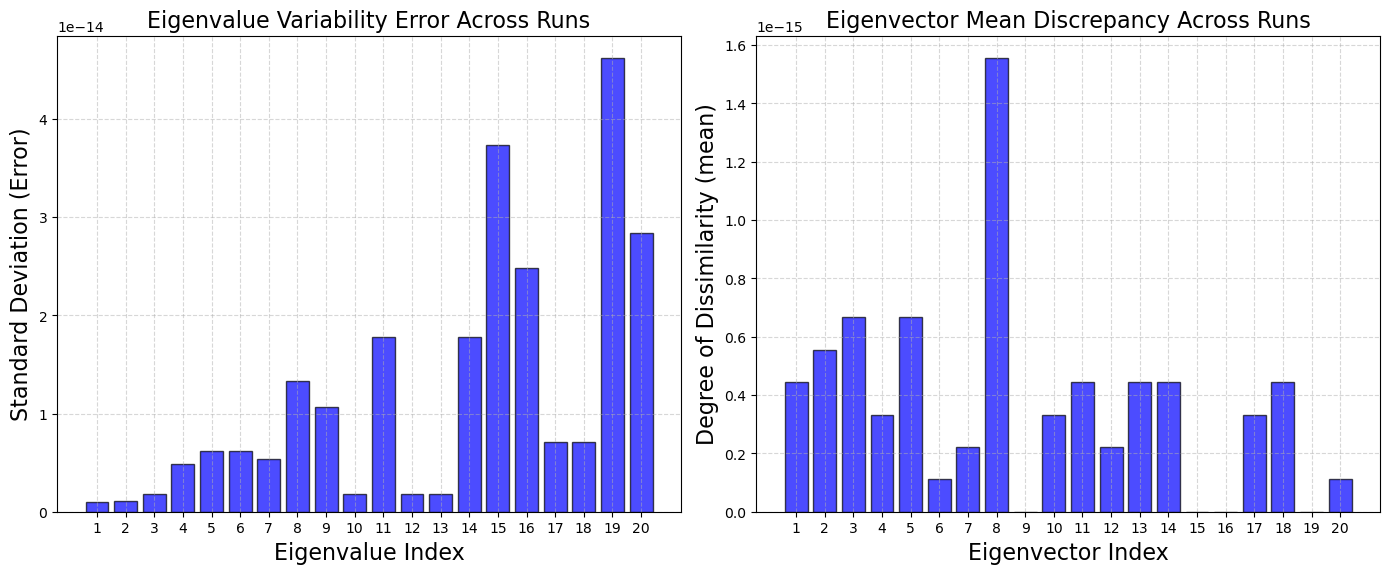

In [16]:
num_runs = 100
order = 4
k = 20

eigval_std, eigvec_dot_mean, dot_mat = fu.stability(num_runs, order, k, N, deltax, x_i, omega)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot the mean and std of eigenvalues
axes[0].bar(range(1, k + 1), eigval_std, color='blue', edgecolor='black', alpha=0.7)
# Labeling the plot
axes[0].set_title("Eigenvalue Variability Error Across Runs", fontsize=16)
axes[0].set_xlabel("Eigenvalue Index", fontsize=16)
axes[0].set_ylabel("Standard Deviation (Error)", fontsize=16)
axes[0].set_xticks(range(1, k + 1))
axes[0].grid(True, linestyle="--", alpha=0.5)

axes[1].bar(range(1, k + 1), eigvec_dot_mean, color='blue', edgecolor='black', alpha=0.7)
# Labeling the plot
axes[1].set_title("Eigenvector Mean Discrepancy Across Runs", fontsize=16)
axes[1].set_xlabel("Eigenvector Index", fontsize=16)
axes[1].set_ylabel("Degree of Dissimilarity (mean)", fontsize=16)
axes[1].set_xticks(range(1, k + 1))
axes[1].grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

## Accurate Discretization - Correctness

Here I would like to test the Accurate Discretization in terms of CORRECTNESS of the solutions.

### Order 2

In [17]:
step = 100
N_min = 100
N_max = 3000
k = 16  # Supponiamo di avere 16 autovalori/autovettori
order = 2
omega = 1

eigval_errors_matrix_2, eigvec_dots_matrix_2, sizes = fu.discretization_size(N_min, N_max, step, k, omega, L, order)

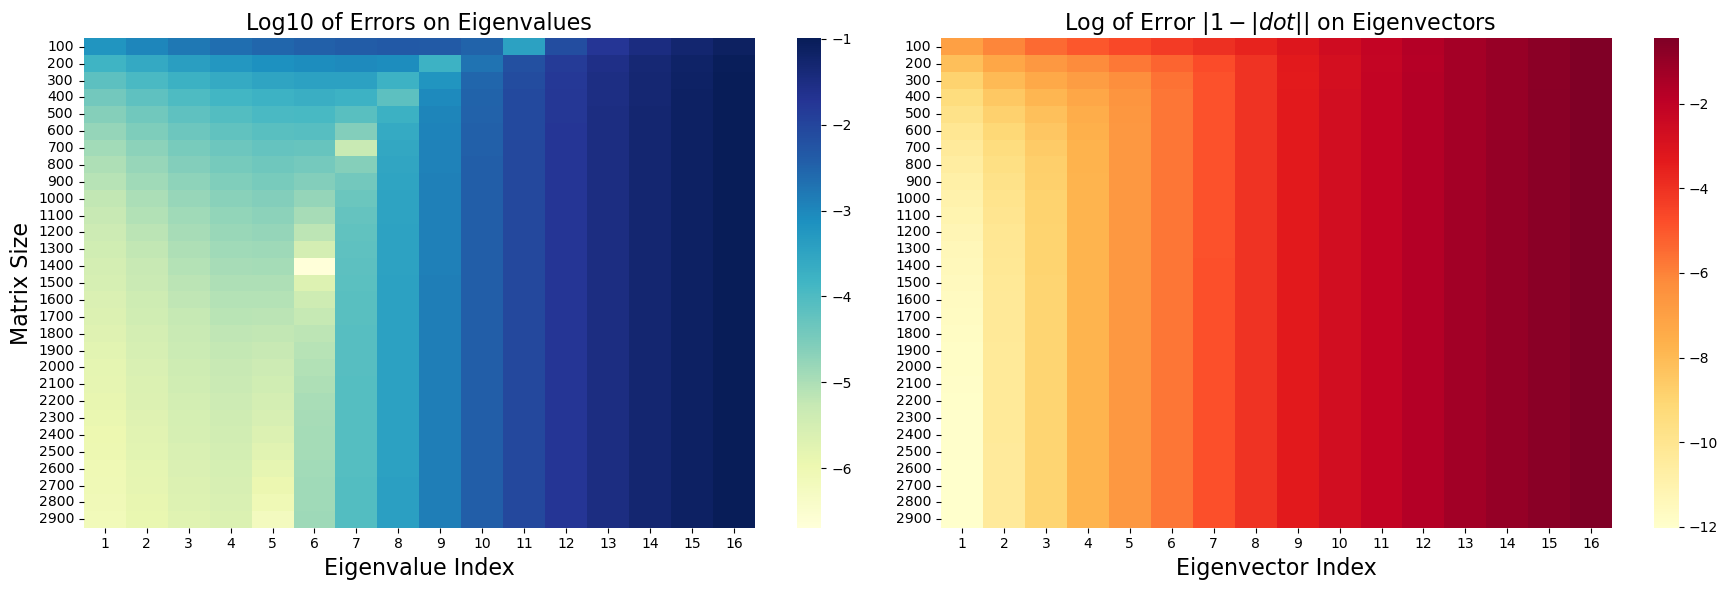

In [18]:
type = "size"

fu.scaling_heatmap(eigval_errors_matrix_2, eigvec_dots_matrix_2, sizes, k, type)

### Order 4 

In [19]:
step = 100
N_min = 100
N_max = 3000 
k = 16  # Supponiamo di avere 16 autovalori/autovettori
order = 4
omega = 1

eigval_errors_matrix_4, eigvec_dots_matrix_4, sizes = fu.discretization_size(N_min, N_max, step, k, omega, L, order)

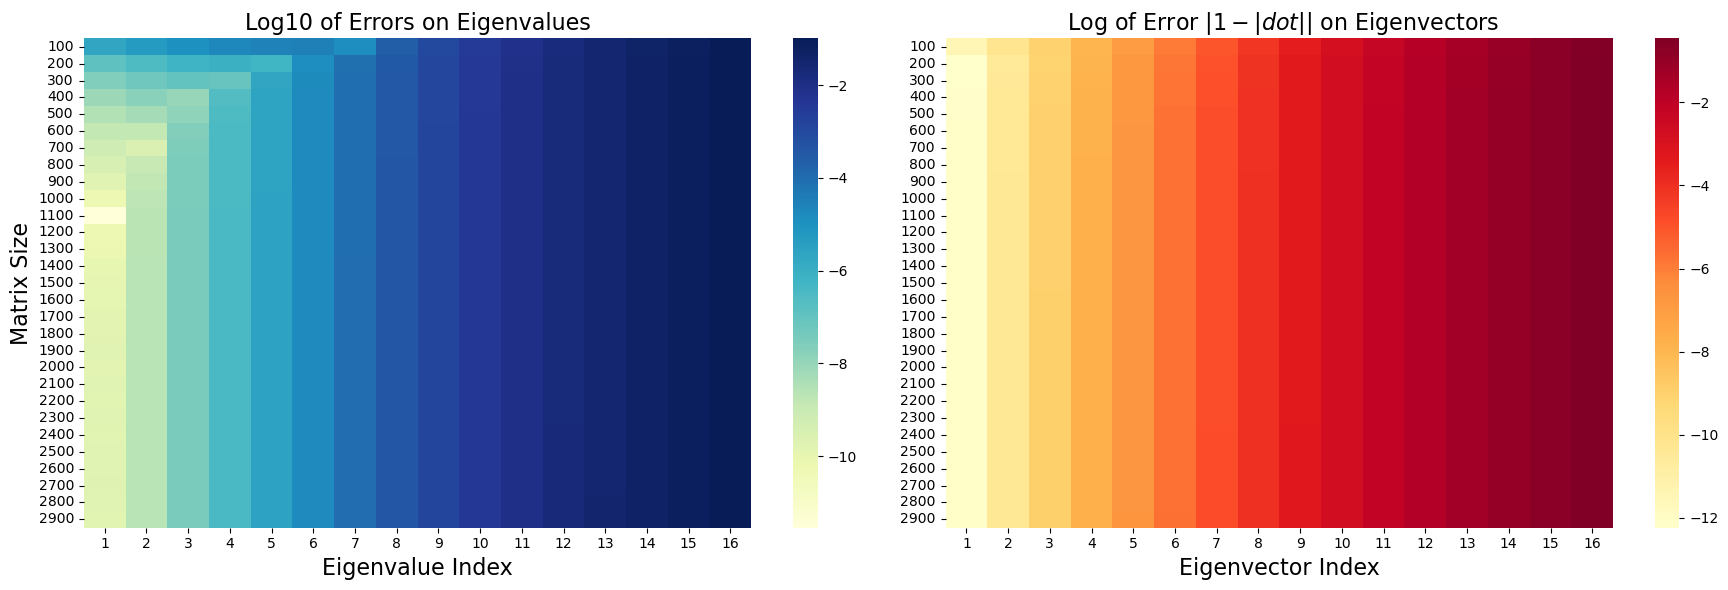

In [20]:
type = "size"

fu.scaling_heatmap(eigval_errors_matrix_4, eigvec_dots_matrix_4, sizes, k, type)

### Variation of Omega

Order 2

In [23]:
N = 1000
omega_step = 0.2
omega_min = 0.1
omega_max = 5.1
k = 16  # Supponiamo di avere 16 autovalori/autovettori
order = 2

eigval_errors_matrix_2, eigvec_dots_matrix_2, omega_sizes = fu.omega_variation(omega_min, omega_max, omega_step, k, N, L, order)

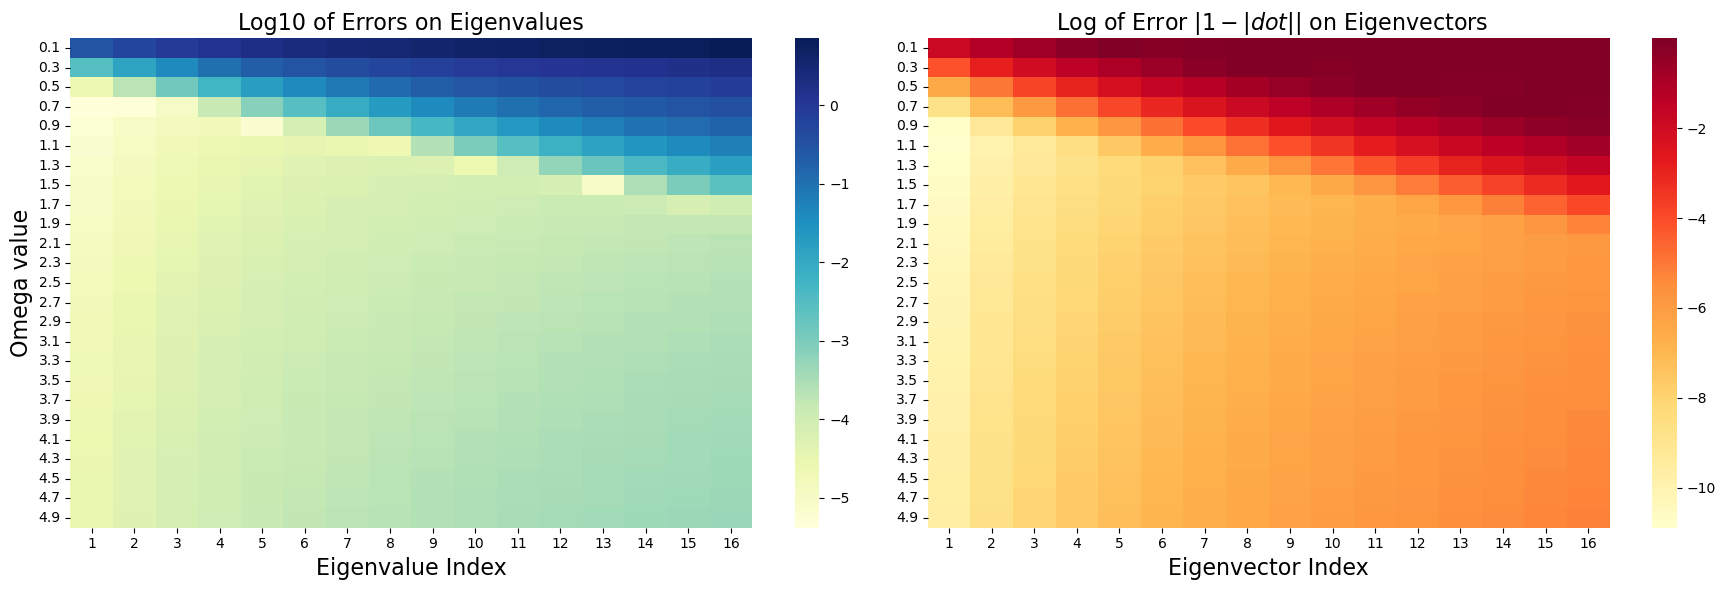

In [24]:
type = "omega"

fu.scaling_heatmap(eigval_errors_matrix_2, eigvec_dots_matrix_2, omega_sizes, k, type)

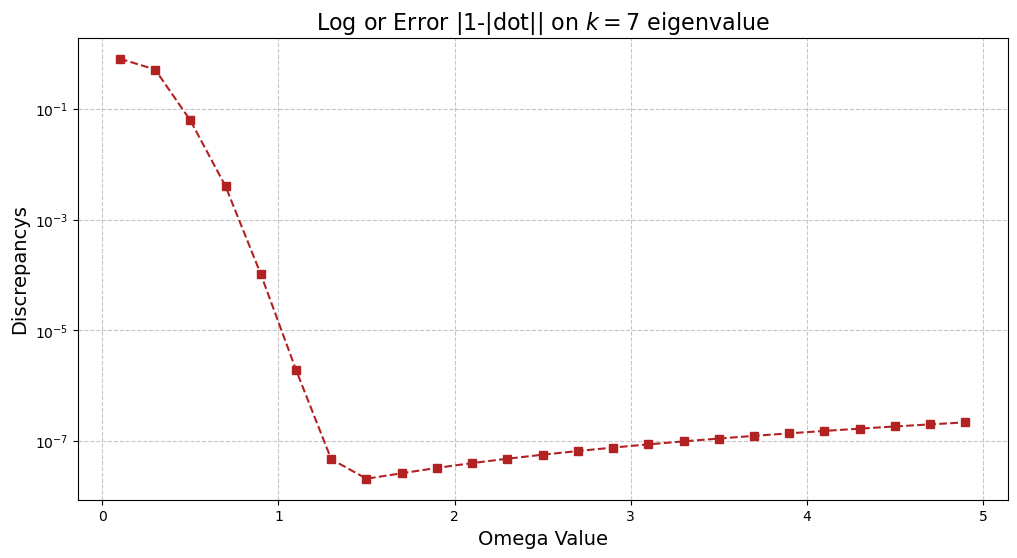

In [26]:
k_7 = eigvec_dots_matrix_2[:, 6]

fig, ax = plt.subplots(figsize=(12, 6))

# ax.plot(omega_sizes, timings[:, 0], "o--", label="Sparse", color="forestgreen")  # Sparse timings
ax.plot(omega_sizes, k_7, "s--", color="firebrick")  # Dense timings
ax.set_yscale("log")  # Use a logarithmic scale for matrix size
ax.set_xlabel("Omega Value", fontsize=14)
ax.set_ylabel("Discrepancys", fontsize=14)
ax.set_title("Log or Error |1-|dot|| on $k=7$ eigenvalue", fontsize=16)

plt.grid(True, linestyle="--", alpha=0.7)  # Add grid for better visualization
plt.show()

Order 4

In [9]:
N = 1000
omega_step = 0.2
omega_min = 0.1
omega_max = 5.1
k = 16  # Supponiamo di avere 16 autovalori/autovettori
order = 4

eigval_errors_matrix_4, eigvec_dots_matrix_4, omega_sizes = fu.omega_variation(omega_min, omega_max, omega_step, k, N, L, order)

/home/sdruci/QIC/QIC/04_Assignement/functions.py:581: RuntimeWarning: divide by zero encountered in log10
  sns.heatmap(np.log10(eigvec_dots_matrix), ax=axes[1], annot=False, cmap="YlOrRd",
/home/sdruci/QIC/QIC/04_Assignement/functions.py:581: RuntimeWarning: invalid value encountered in log10
  sns.heatmap(np.log10(eigvec_dots_matrix), ax=axes[1], annot=False, cmap="YlOrRd",


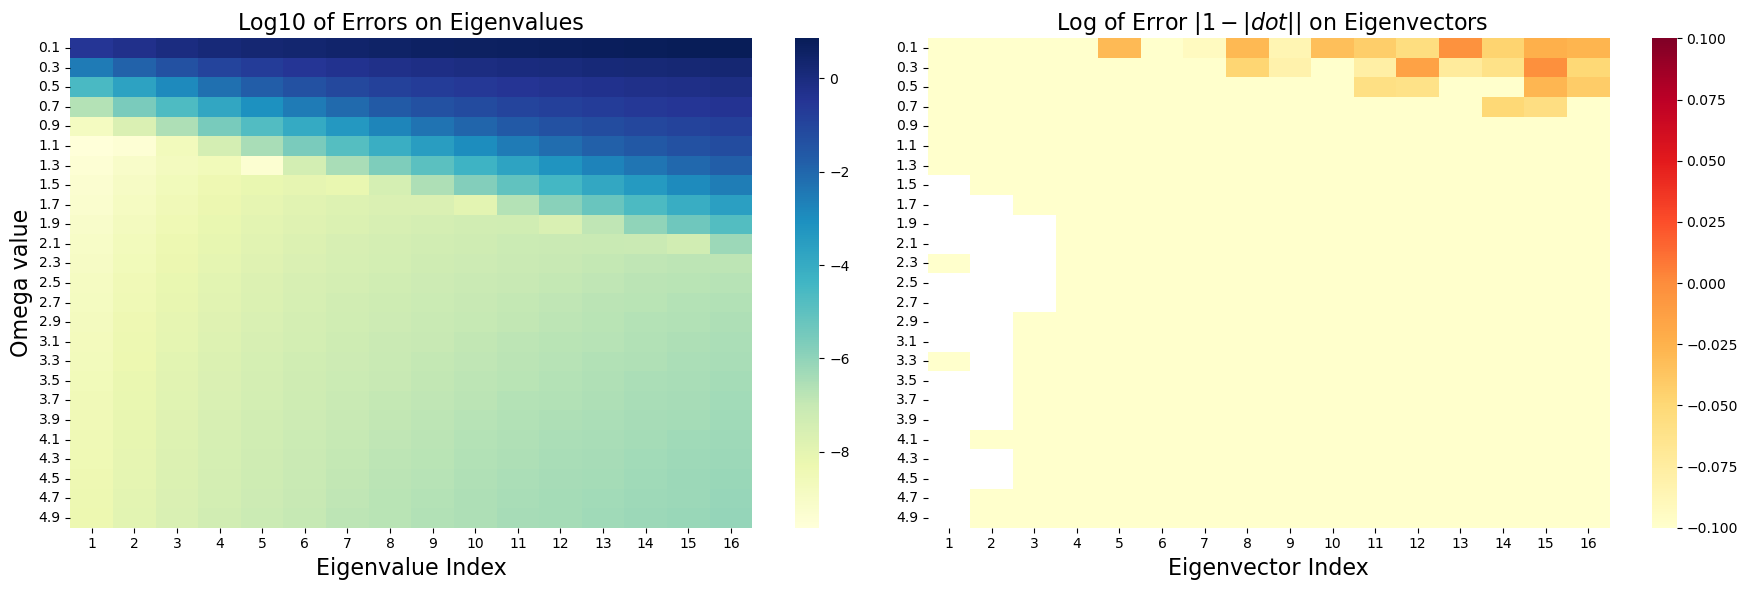

In [10]:
type = "omega"

fu.scaling_heatmap(eigval_errors_matrix_4, eigvec_dots_matrix_4, omega_sizes, k, type)

## Accurate Discretization - Stability

Now i test the Accurate Discretization in terms of Stability

Order 2

In [25]:
order = 2

num_runs = 100

L = 5
omega = 5
k = 20
N_min = 100
N_max = 1000
step = 100

sizes = list(range(N_min, N_max, step))
num_sizes = len(sizes)

eigval_errors_matrix = np.zeros((num_sizes, k))
eigvec_dots_matrix = np.zeros((num_sizes, k))

for idx, size in enumerate(sizes):
    deltax = (2*L)/size
    x_i = np.array([(((2*L)/size)*i - L) for i in range(size)])
    
    eigenvalues_std, eigvec_dot_mean, dot_mat = fu.stability(num_runs, order, k, size, deltax, x_i, omega)

    eigval_errors_matrix[idx, :] = eigenvalues_std
    eigvec_dots_matrix[idx, :] = eigvec_dot_mean


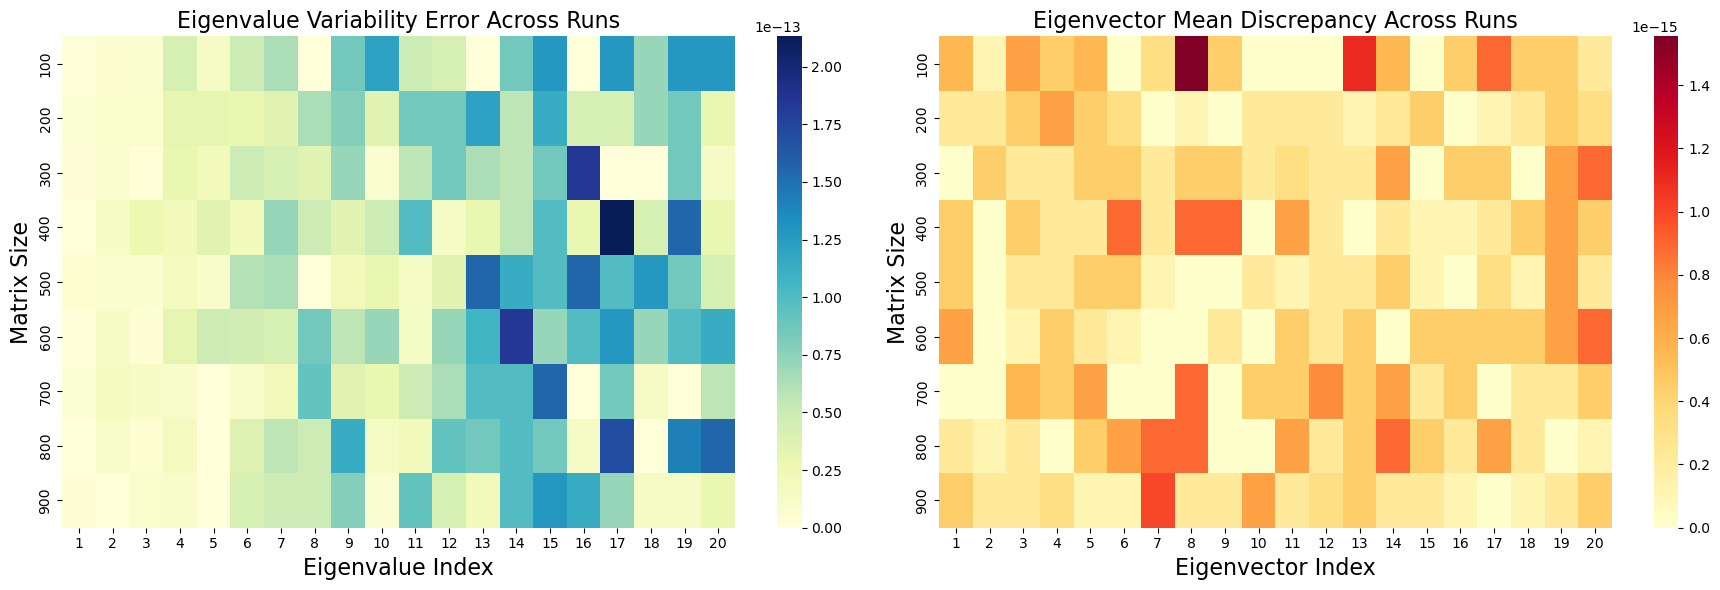

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Heatmap per gli errori sugli autovalori
sns.heatmap(eigval_errors_matrix, ax=axes[0], annot=False, cmap="YlGnBu", 
                xticklabels=np.arange(1, k+1), yticklabels=sizes)
axes[0].set_title("Eigenvalue Variability Error Across Runs", fontsize=16)
axes[0].set_xlabel("Eigenvalue Index", fontsize=16)
axes[0].set_ylabel("Matrix Size", fontsize=16)

# Heatmap per il prodotto scalare degli autovettori
sns.heatmap(eigvec_dots_matrix, ax=axes[1], annot=False, cmap="YlOrRd", 
                xticklabels=np.arange(1, k+1), yticklabels=sizes)
axes[1].set_title("Eigenvector Mean Discrepancy Across Runs", fontsize=16)
axes[1].set_xlabel("Eigenvector Index", fontsize=16)
axes[1].set_ylabel("Matrix Size", fontsize=16)

plt.tight_layout()
plt.show()

Order 4

In [27]:
order = 4

num_runs = 100

L = 5
omega = 5
k = 20
N_min = 100
N_max = 1000
step = 100

sizes = list(range(N_min, N_max, step))
num_sizes = len(sizes)

eigval_errors_matrix = np.zeros((num_sizes, k))
eigvec_dots_matrix = np.zeros((num_sizes, k))

for idx, size in enumerate(sizes):
    deltax = (2*L)/size
    x_i = np.array([(((2*L)/size)*i - L) for i in range(size)])
    
    eigenvalues_std, eigvec_dot_mean, dot_mat = fu.stability(num_runs, order, k, size, deltax, x_i, omega)

    eigval_errors_matrix[idx, :] = eigenvalues_std
    eigvec_dots_matrix[idx, :] = eigvec_dot_mean


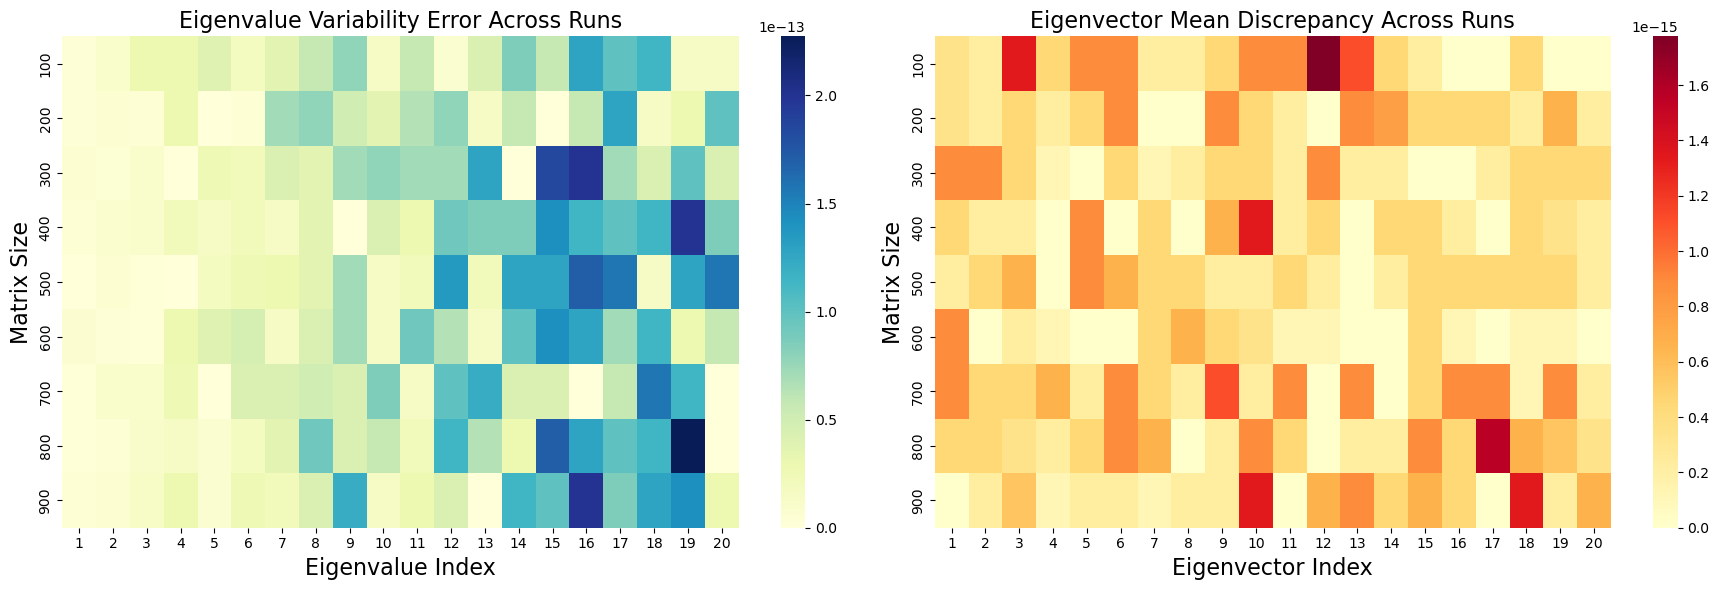

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Heatmap per gli errori sugli autovalori
sns.heatmap(eigval_errors_matrix, ax=axes[0], annot=False, cmap="YlGnBu", 
                xticklabels=np.arange(1, k+1), yticklabels=sizes)
axes[0].set_title("Eigenvalue Variability Error Across Runs", fontsize=16)
axes[0].set_xlabel("Eigenvalue Index", fontsize=16)
axes[0].set_ylabel("Matrix Size", fontsize=16)

# Heatmap per il prodotto scalare degli autovettori
sns.heatmap(eigvec_dots_matrix, ax=axes[1], annot=False, cmap="YlOrRd", 
                xticklabels=np.arange(1, k+1), yticklabels=sizes)
axes[1].set_title("Eigenvector Mean Discrepancy Across Runs", fontsize=16)
axes[1].set_xlabel("Eigenvector Index", fontsize=16)
axes[1].set_ylabel("Matrix Size", fontsize=16)

plt.tight_layout()
plt.show()

## Efficiency

I want to test the efficieny in terms of 
- scaling the size of the discretization step
- scaling of omega
- for different order 

For this reason I perform a benchmark for the function hamilton_gen varying the discretization step and the omega value. So, this is basically equivalent of testing at the same time also the functions discretization_size and omega_variation, which are basically the previous function varying the parameters size and omega

Order 2

test hamiltonian_gen for the size and omega of the matrix

In [29]:
# Parameters
order = 2

step = 100
N_min = 100
N_max = 3000
k = 16
L = 5

omega_step = 0.2
omega_min = 0.1
omega_max = 5.1

# Sizes and frequencies
sizes = list(range(N_min, N_max, step))
omega_sizes = list(np.round(np.arange(omega_min, omega_max, omega_step), decimals=2))

# Initialize the CPU times matrix
cpu_times_matrix = np.zeros((len(sizes), len(omega_sizes)))

# Loop to calculate CPU times
for idx_1, size in enumerate(sizes):
    deltax = (2 * L) / size
    x_i = np.array([((2 * L) / size) * i - L for i in range(size)])

    for idx_2, omega in enumerate(omega_sizes):
        start_time = time.time()
        _, eigenvalues, eigenvectors = fu.hamiltonian_gen(size, deltax, x_i, omega, order)
        end_time = time.time()

        # Store the elapsed time in the matrix
        elapsed_time = end_time - start_time
        cpu_times_matrix[idx_1, idx_2] = elapsed_time

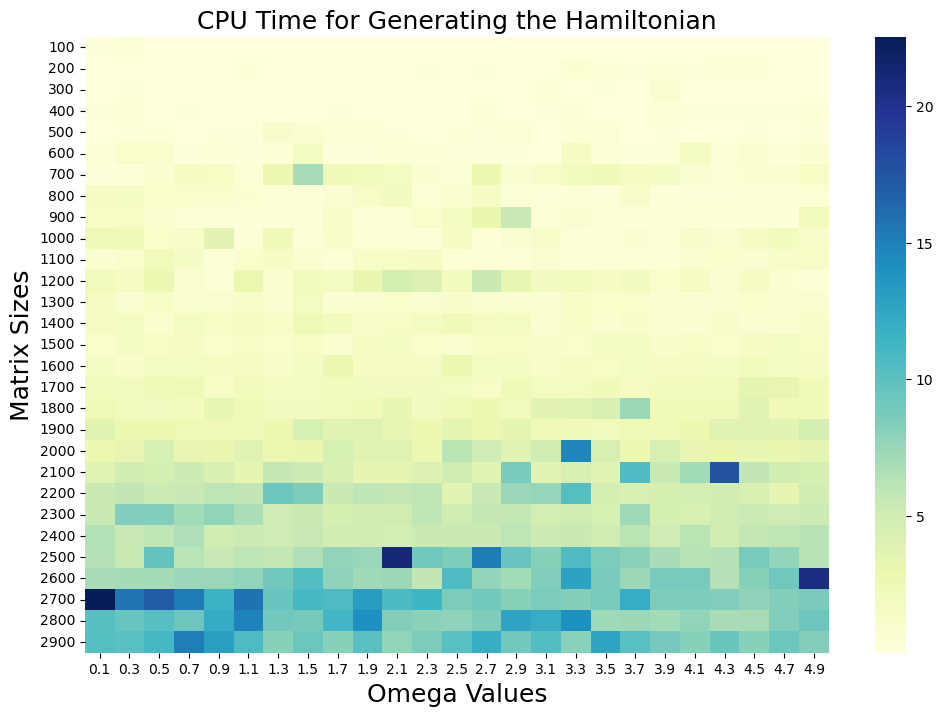

In [30]:
# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cpu_times_matrix, annot=False, cmap="YlGnBu", 
            xticklabels=omega_sizes, yticklabels=sizes)
plt.title("CPU Time for Generating the Hamiltonian", fontsize=18)
plt.xlabel("Omega Values", fontsize=18)
plt.ylabel("Matrix Sizes", fontsize=18)
plt.show()

Order 4

test hamiltonian_gen for the size and omega of the matrix

In [31]:
# Parameters
order = 4

step = 100
N_min = 100
N_max = 3000
k = 16
L = 5

omega_step = 0.2
omega_min = 0.1
omega_max = 5.1

# Sizes and frequencies
sizes = list(range(N_min, N_max, step))
omega_sizes = list(np.round(np.arange(omega_min, omega_max, omega_step), decimals=2))

# Initialize the CPU times matrix
cpu_times_matrix = np.zeros((len(sizes), len(omega_sizes)))

# Loop to calculate CPU times
for idx_1, size in enumerate(sizes):
    deltax = (2 * L) / size
    x_i = np.array([((2 * L) / size) * i - L for i in range(size)])

    for idx_2, omega in enumerate(omega_sizes):
        start_time = time.time()
        _, eigenvalues, eigenvectors = fu.hamiltonian_gen(size, deltax, x_i, omega, order)
        end_time = time.time()

        # Store the elapsed time in the matrix
        elapsed_time = end_time - start_time
        cpu_times_matrix[idx_1, idx_2] = elapsed_time

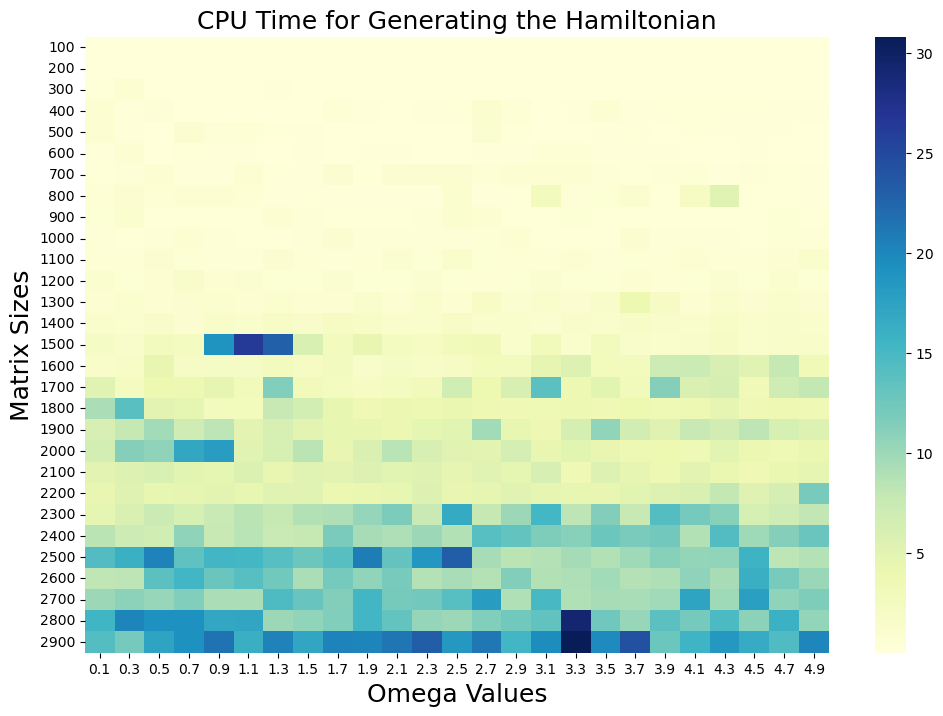

In [32]:
# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cpu_times_matrix, annot=False, cmap="YlGnBu", 
            xticklabels=omega_sizes, yticklabels=sizes)
plt.title("CPU Time for Generating the Hamiltonian", fontsize=18)
plt.xlabel("Omega Values", fontsize=18)
plt.ylabel("Matrix Sizes", fontsize=18)
plt.show()

## Sparse Matrices 

The matrix of the hamiltonian do not occupy all entries

So, I use SPARSE MATRICES in order to see which is the value of k after which it is convenient to use sparse matrices.

### First Eigenvalue

Order 2

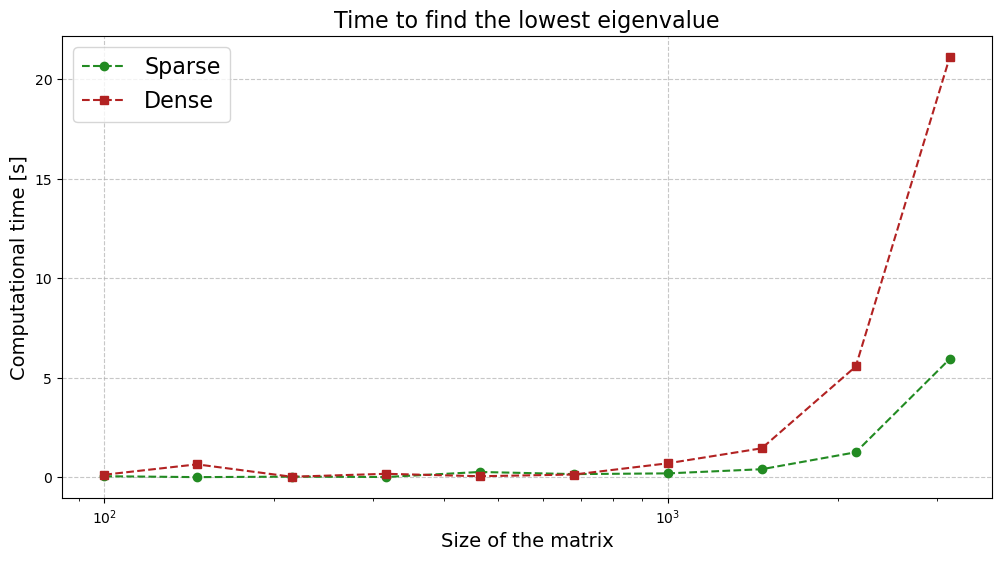

In [33]:
order = 2

L = 5
omega = 5
sizes = list(np.logspace(2, 3.5, 10).astype(int))

A, timings = spma.sparse_matrix_one_eig(L, omega, sizes, order)

Order 4

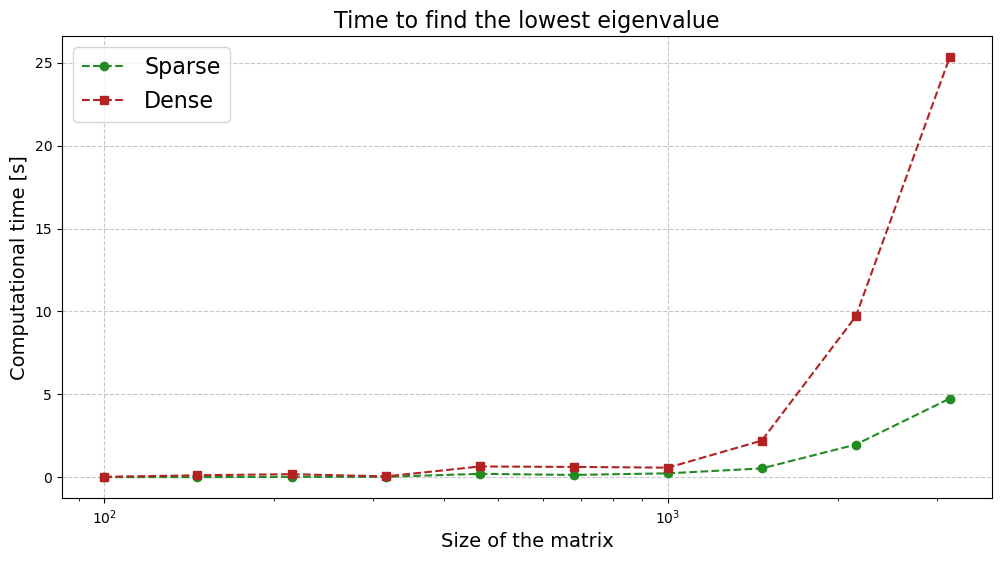

In [34]:
order = 4

L = 5
omega = 5
sizes = list(np.logspace(2, 3.5, 10).astype(int))

A, timings = spma.sparse_matrix_one_eig(L, omega, sizes, order)

### Eigenvalues from 1 to 16

Order 2

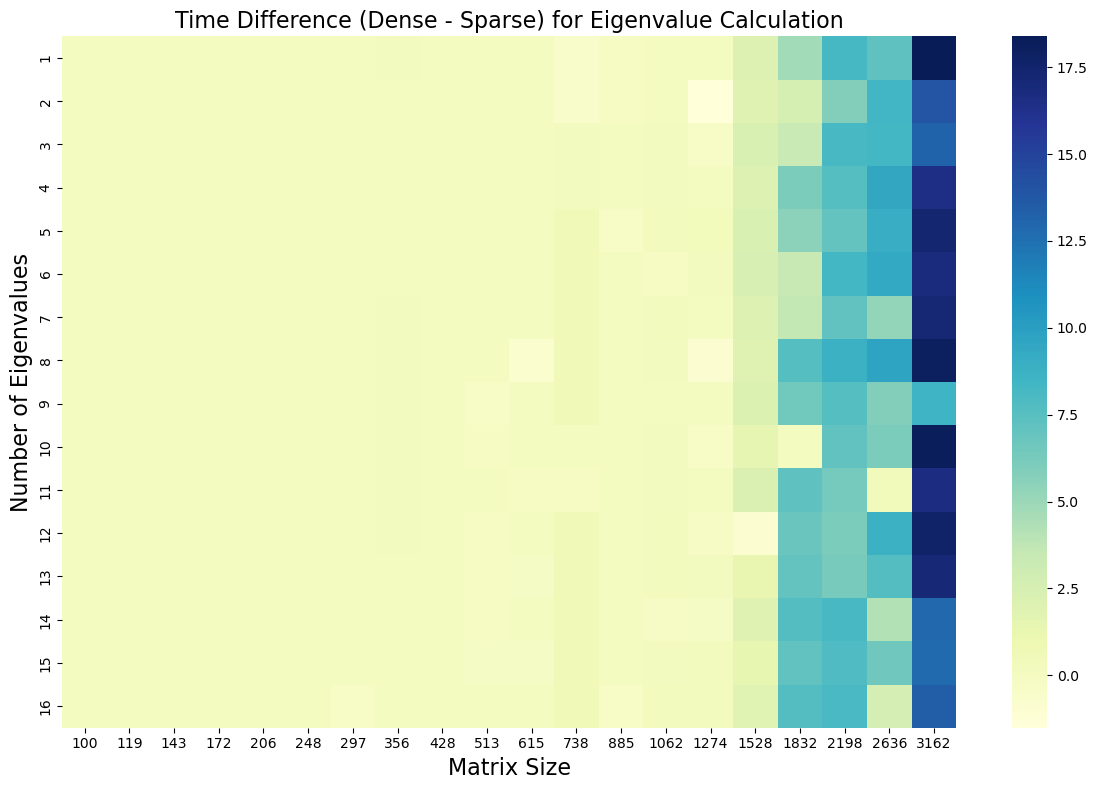

In [35]:
order = 2

L = 5
omega = 5
sizes = list(np.logspace(2, 3.5, 20).astype(int))
num_eig = 16

A, timings = spma.sparse_matrix_heatmap(L, omega, sizes, order, num_eig)

Order 4

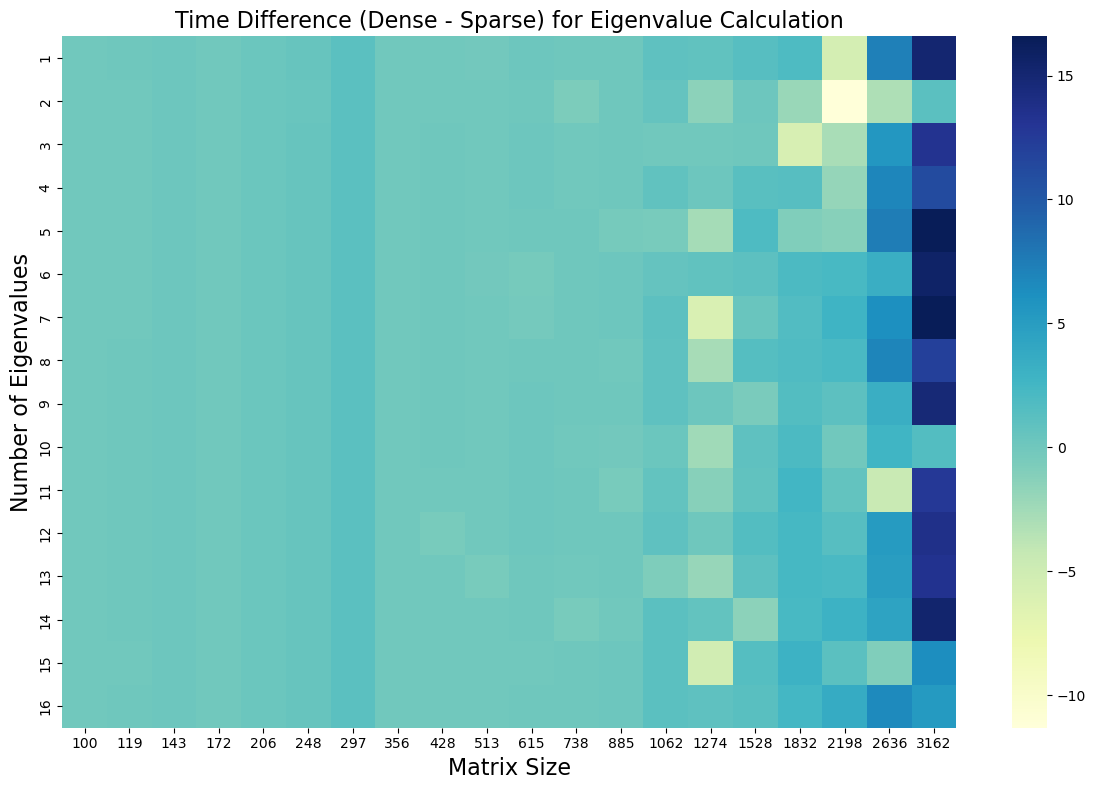

In [36]:
order = 4

L = 5
omega = 5
sizes = list(np.logspace(2, 3.5, 20).astype(int))
num_eig = 16

A, timings = spma.sparse_matrix_heatmap(L, omega, sizes, order, num_eig)